In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from rfpimp import *

In [3]:
df = pd.read_csv("rent.csv", parse_dates=['created'])
df_clean = df[(df.price>1_000) & (df.price<10_000)]
df_clean = df_clean[(df_clean.longitude!=0) | (df_clean.latitude!=0)]
df_clean = df_clean[(df_clean['latitude']>40.55) &
                    (df_clean['latitude']<40.94) &
                    (df_clean['longitude']>-74.1) &
                    (df_clean['longitude']<-73.67)]
df = df_clean

In [5]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']
X, y = df[numfeatures], df['price']
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)
oob_baseline = rf.oob_score_
print(oob_baseline)

0.8679483256289904


In [6]:
print(f"{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

2,431,964 tree nodes and 35.0 median tree height


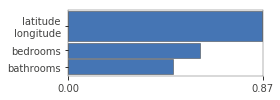

In [7]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')
    
showimp(rf, X, y)

In [8]:
print(df['interest_level'].value_counts())

low       33270
medium    11203
high       3827
Name: interest_level, dtype: int64


In [9]:
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
print(df['interest_level'].value_counts())

1    33270
2    11203
3     3827
Name: interest_level, dtype: int64


In [10]:
def test(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

X, y = df[['interest_level']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87053 using 3,023,206 tree nodes with 35.0 median tree height


In [11]:
print(len(df['manager_id'].unique()), len(df['building_id'].unique()), len(df['display_address'].unique()))

3409 7417 8680


In [12]:
df['display_address_cat'] = df['display_address'].astype('category').cat.as_ordered()
df['display_address_cat'] = df['display_address_cat'].cat.codes + 1

In [13]:
X, y = df[['display_address_cat']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86586 using 3,122,758 tree nodes with 37.0 median tree height


In [14]:
print(df['manager_id'].value_counts().head(5))

e6472c7237327dd3903b3d6f6a94515a    2509
6e5c10246156ae5bdcd9b487ca99d96a     695
8f5a9c893f6d602f4953fcc0b8e6e9b4     404
62b685cc0d876c3a1a51d63a0d6a8082     396
cb87dadbca78fad02b388dc9e8f25a5b     370
Name: manager_id, dtype: int64


In [15]:
managers_count = df['manager_id'].value_counts()
df['mgr_apt_count'] = df['manager_id'].map(managers_count)

In [16]:
X, y = df[['display_address_cat','mgr_apt_count']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86420 using 4,571,612 tree nodes with 41.0 median tree height


In [17]:
df['description'] = df['description'].fillna('')
df['description'] = df['description'].str.lower() # normalize to lower case
df['features'] = df['features'].fillna('') # fill missing w/blanks
df['features'] = df['features'].str.lower() # normalize to lower case


In [18]:
# has apartment been renovated?
df['renov'] = df['description'].str.contains("renov")

for w in ['doorman', 'parking', 'garage', 'laundry', 
          'Elevator', 'fitness center', 'dishwasher']:
    df[w] = df['features'].str.contains(w)
df[['doorman', 'parking', 'garage', 'laundry']].head(5)

,doorman,parking,garage,laundry
0,False,False,False,False
1,True,False,False,False
2,False,False,False,True
3,False,False,False,False
4,False,False,False,False


In [19]:
df["num_desc_words"] = df["description"].apply(lambda x: len(x.split()))
df["num_features"] = df["features"].apply(lambda x: len(x.split(",")))

In [20]:
df["num_photos"] = df["photos"].apply(lambda x: len(x.split(",")))

In [21]:
textfeatures = [
    'num_photos', 'num_desc_words', 'num_features',
    'doorman', 'parking', 'garage', 'laundry', 
    'Elevator', 'fitness center', 'dishwasher',
    'renov'
]
X, y = df[textfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86292 using 4,765,380 tree nodes with 43.0 median tree height


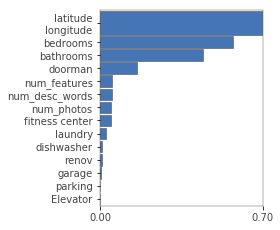

In [22]:
showimp(rf, X, y)

In [24]:
df["beds_to_baths"] = df["bedrooms"]/(df["bathrooms"]+1) # avoid div by 0
X, y = df[['beds_to_baths']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86839 using 2,433,354 tree nodes with 35.0 median tree height


In [25]:
df["beds_per_price"] = df["bedrooms"] / df["price"]
X, y = df[['beds_per_price']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.98621 using 1,311,596 tree nodes with 31.0 median tree height


In [26]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.20)
df_train = df_train.copy()
df_train['beds_per_price'] = df_train['bedrooms'] / df_train["price"]
df_train[['beds_per_price','bedrooms']].head(5)

,beds_per_price,bedrooms
6794,0.000573,1
41217,0.000301,1
48750,0.001071,3
11915,0.000000,0
33441,0.000857,3


In [27]:
bpmap = dict(zip(df_train["bedrooms"],df_train["beds_per_price"]))
df_test = df_test.copy()
df_test["beds_per_price"] = df_test["bedrooms"].map(bpmap)
avg = np.mean(df_test['beds_per_price'])
df_test['beds_per_price'].fillna(avg, inplace=True)
print(df_test['beds_per_price'].head(5))

2683     0.000000
39378    0.001026
48037    0.000000
44371    0.000408
42219    0.001026
Name: beds_per_price, dtype: float64


In [29]:
X_train, y_train = df_train[['beds_per_price']+numfeatures], df_train['price']
X_test, y_test = df_test[['beds_per_price']+numfeatures], df_test['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
oob_overfit = rf.score(X_test, y_test) # don't test training set
print(f"OOB R^2 {oob_overfit:.5f}")
print(f"{rfnnodes(rf):,d} nodes, {np.median(rfmaxdepths(rf))} median height")

OOB R^2 -0.38451
1,164,264 nodes, 31.0 median height


In [30]:
df.groupby('building_id').mean()[['price']].head(5)

,price
building_id,
0,3195.9321
00005cb939f9986300d987652c933e15,3399.0000
00024d77a43f0606f926e2312513845c,2000.0000
000ae4b7db298401cdae2b0ba1ea8146,2400.0000
0012f1955391bca600ec301035b97b65,3700.0000


In [31]:
from category_encoders.target_encoder import TargetEncoder
df = df.reset_index() # not sure why TargetEncoder needs this but it does
targetfeatures = ['building_id']
encoder = TargetEncoder(cols=targetfeatures)
encoder.fit(df, df['price'])
df_encoded = encoder.transform(df, df['price'])

X, y = df_encoded[targetfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87257 using 2,745,934 tree nodes with 39.0 median tree height


In [32]:
df_train, df_test = train_test_split(df, test_size=0.20)

# TargetEncoder needs the resets, not sure why
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train[numfeatures]
y_train = df_train['price']
X_test = df_test[numfeatures]
y_test = df_test['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
s_validation = rf.score(X_test, y_test)
print(f"{s_validation:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.858321 score 2,124,088 tree nodes and 35.0 median tree height


In [33]:
enc = TargetEncoder(cols=targetfeatures)
enc.fit(df_train, df_train['price'])
df_train_encoded = enc.transform(df_train, df_train['price'])
df_test_encoded = enc.transform(df_test)

X_train = df_train_encoded[targetfeatures+numfeatures]
y_train = df_train_encoded['price']
X_test = df_test_encoded[targetfeatures+numfeatures]
y_test = df_test_encoded['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
s_tenc_validation = rf.score(X_test, y_test)
print(f"{s_tenc_validation:.4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.8576 score 2,379,492 tree nodes and 37.0 median tree height


In [34]:
hoods = {
    "hells" : [40.7622, -73.9924],
    "astoria" : [40.7796684, -73.9215888],
    "Evillage" : [40.723163774, -73.984829394],
    "Wvillage" : [40.73578, -74.00357],
    "LowerEast" : [40.715033, -73.9842724],
    "UpperEast" : [40.768163594, -73.959329496],
    "ParkSlope" : [40.672404, -73.977063],
    "Prospect Park" : [40.93704, -74.17431],
    "Crown Heights" : [40.657830702, -73.940162906],
    "financial" : [40.703830518, -74.005666644],
    "brooklynheights" : [40.7022621909, -73.9871760513],
    "gowanus" : [40.673, -73.997]
}

In [35]:
for hood,loc in hoods.items():
    # compute manhattan distance
    df[hood] = np.abs(df.latitude - loc[0]) + np.abs(df.longitude - loc[1])

In [36]:
hoodfeatures = list(hoods.keys())
X, y = df[numfeatures+hoodfeatures], df['price']
rf, oob_hood = test(X, y)

OOB R^2 0.87335 using 2,412,732 tree nodes with 43.0 median tree height


In [37]:
X = X.drop(['longitude','latitude'],axis=1)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)
print(f"{rf.oob_score_:.4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.8698 score 2,422,538 tree nodes and 41.0 median tree height


In [38]:
X = df[['interest_level']+textfeatures+hoodfeatures+numfeatures]
rf, oob_combined = test(X, y)

OOB R^2 0.87865 using 4,839,026 tree nodes with 44.0 median tree height
